This implementation is a Tensorflow 2.0 variation of the following tutorial https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2

In [ ]:
import tensorflow as tf
from tqdm import tqdm

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((-1*np.ones((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])


The loss function adopted in this project is the following:

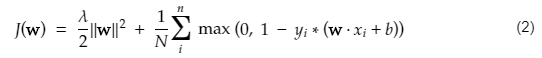

In [ ]:
input_dim = features.shape[1]
output_dim = 1
learning_rate = 0.01
reg_strength = 1

tf.random.set_seed(42)
# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def predict(x):
    return tf.sign(tf.tensordot(x,w, 1) + b) 

def compute_cost(x, y, b):
    # computing hinge loss
    N = x.shape[0]
    distances = 1 - y * (tf.tensordot(x, w, 1) + b) # 
    
    distances = tf.where(distances > 0, distances, 0)  # making the max between our distance and zero
    hinge_loss = reg_strength * (tf.reduce_sum(distances) / N) # updating the loss using the computed loss function
    
    # calculate the final cost
    cost = (1 / 2) * tf.square(w) + hinge_loss
    return tf.reduce_mean(cost)

@tf.function
def fit(x, y):
    with tf.GradientTape() as tape:
        loss = compute_cost(x, y, b)
        # We don't need to actually compute the derivative, the tensorflow does that for us!
        dloss_dw, dloss_db = tape.gradient(loss, [w, b]) 
    w.assign_sub(learning_rate * dloss_dw)
    b.assign_sub(learning_rate * dloss_db)
    return loss

In [ ]:
# shuffle the data.
indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

# create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

losses = []
for epoch in tqdm(range(10)):
    epoch_losses = []
    for step, (x, y) in enumerate(dataset):
        loss = fit(x, y)
        epoch_losses.append(loss)
    losses.append(np.mean(epoch_losses))

In [ ]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = predict(features)

In [ ]:
accuracy_score(labels, y_pred)